In [1]:
import random
import os
import math
import itertools as it

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils

from tqdm.notebook import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Data preparation

## Data loader class

In [2]:
def show_image(image, label=None, text=""):
    image = np.transpose(image.cpu().numpy(), (1, 2, 0))
    if image.shape[2] == 1:
        image = image[:, :, 0]

    plt.figure(figsize=(4, 8))
    plt.imshow(image)
    title = "unlabeled" if label is None else str(label.item())
    if text:
        title += ", " + text
    plt.title(title)
    plt.axis("off")
    plt.show()


def show_pair(image1, image2, label=None, text=""):
    image1, image2 = image1.cpu().numpy(), image2.cpu().numpy()
    joint_image = np.concatenate([image1, image2], axis=2)
    joint_image = np.transpose(joint_image, (1, 2, 0))
    if joint_image.shape[2] == 1:
        joint_image = joint_image[:, :, 0]

    plt.figure(figsize=(4, 8))
    plt.imshow(joint_image)
    title = "unlabeled" if label is None else str(label.item())
    if text:
        title += ", " + text
    plt.title(title)
    plt.axis("off")
    plt.show()


class DataPreparation:
    @staticmethod
    def prepare_MNIST(cls):
        """ Uses MNIST to create and save the following datasets:
                - classes is a list of form:
                    l[i] = images of the digit i from the MNIST train set,
                - oneshot is a list of form:
                    l[i] = an example image of the digit i. """
        if "data" not in os.listdir():
            os.mkdir("data")
        transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        trainset = torchvision.datasets.MNIST(os.path.join("data", "downloaded"), transform=transform, download=True)
        train_classes = [[] for _ in range(10)]
        for image, label in trainset:
            train_classes[label].append(image)
        oneshot = [images[-1] for images in train_classes]

        testset = torchvision.datasets.MNIST(os.path.join("data", "downloaded"), transform=transform, download=True, train=False)
        test_classes = [[] for _ in range(10)]
        for image, label in testset:
            test_classes[label].append(image)

        if "processed" not in os.listdir("data"):
            os.mkdir(os.path.join("data", "processed"))
        if cls.__name__ not in os.listdir(os.path.join("data", "processed")):
            os.mkdir(os.path.join("data", "processed", cls.__name__))

        torch.save(train_classes, os.path.join("data", "processed", cls.__name__, "train_classes.pth"))
        torch.save(test_classes, os.path.join("data", "processed", cls.__name__, "test_classes.pth"))
        torch.save(oneshot, os.path.join("data", "processed", cls.__name__, "oneshot.pth"))

        return train_classes, test_classes, oneshot


class BaseDataset:
    labels = None

    @classmethod
    def prepare_data(cls):
        raise NotImplementedError

    def __init__(self):
        self._classes = None # dataset grouped by classes
        self._test_classes = None # dedicated test set grouped by classes
        self._oneshot = None # oneshot sample

        self._unlabeled = None # unlabeled pairs
        self._trainset = None # labeled pairs in training set
        self._testset = None # labeled pairs in test set

        if not os.path.exists(os.path.join("data", "processed", self.__class__.__name__)):
            self._classes, self._test_classes, self._oneshot = self.prepare_data()

    @property
    def classes(self):
        if self._classes is None:
            self.load_classes()
        return self._classes
    
    @property
    def test_classes(self):
        if self._test_classes is None:
            self.load_classes()
        return self._test_classes

    @property
    def oneshot(self):
        if self._oneshot is None:
            self.load_oneshot()
        return self._oneshot

    @property
    def unlabeled(self):
        if self._unlabeled is None:
            raise AttributeError("Use sample_unlabeled or load_unlabeled first.")
        return self._unlabeled

    @property
    def trainset(self):
        if self._trainset is None:
            raise AttributeError("Use sample_traintest or load_traintest first.")
        return self._trainset
    
    @property
    def testset(self):
        if self._testset is None:
            raise AttributeError("Use sample_traintest or load_traintest first.")
        return self._testset
    
    def sample_traintest(self, *args, **kwargs):
        raise NotImplementedError

    def save_traintest(self):
        dataset_name = self.__class__.__name__
        torch.save(self.trainset, os.path.join("data", "processed", dataset_name, "train_sample.pth"))
        torch.save(self.testset, os.path.join("data", "processed", dataset_name, "test_sample.pth"))

    def save_unlabeled(self):
        dataset_name = self.__class__.__name__
        torch.save(self.unlabeled, os.path.join("data", "processed", dataset_name, "unlabeled.pth"))

    def load_traintest(self):
        dataset_name = self.__class__.__name__
        try:
            self._trainset = torch.load(
                os.path.join("data", "processed", dataset_name, "train_sample.pth")
            )
            self._testset = torch.load(
                os.path.join("data", "processed", dataset_name, "test_sample.pth")
            )
            return self._trainset, self._testset
        except FileNotFoundError as e:
            e.args = (
                "Either trainset or testset cannot be loaded. Use sample_traintest and save_traintest first.",
            )
            raise

    def load_unlabeled(self):
        dataset_name = self.__class__.__name__
        try:
            self._unlabeled = torch.load(
                os.path.join("data", "processed", dataset_name, "unlabeled.pth")
            )
            return self._unlabeled
        except FileNotFoundError as e:
            e.args = (
                "unlabeled cannot be loaded. Use sample_unlabeled and save_unlabeled first.",
            )
            raise

    def load_classes(self):
        dataset_name = self.__class__.__name__
        try:
            self._classes = torch.load(os.path.join("data", "processed", dataset_name, "train_classes.pth"))
            self._test_classes = torch.load(os.path.join("data", "processed", dataset_name, "test_classes.pth"))
        except FileNotFoundError:
            self._classes, self._test_classes, self._oneshot = self.prepare_data()
        return self._classes

    def load_oneshot(self):
        dataset_name = self.__class__.__name__
        try:
            self._oneshot = torch.load(os.path.join("data", "processed", dataset_name, "oneshot.pth"))
            return self._oneshot
        except FileNotFoundError:
            self._classes, self._oneshot = self.prepare_data()
        return self._oneshot
    
    def show_oneshot(self):
        oneshot = [image.numpy().transpose((1, 2, 0)) for image in self.oneshot]
        row1 = np.concatenate(oneshot[:5], axis=1)
        row2 = np.concatenate(oneshot[5:], axis=1)
        joint_image = np.concatenate([row1, row2], axis=0)
        if joint_image.shape[2] == 1:
            joint_image = joint_image[:, :, 0]

        plt.figure(figsize=(8, 20))
        plt.imshow(joint_image)

        plt.title("One-shot sample")
        plt.axis("off")
        plt.show()


class SiameseDataset(BaseDataset):
    _k, _l = None, None # balancing_numbers(len(labels))

    def __init__(self):
        BaseDataset.__init__(self)

        self._positive = None # positive pairs in training set
        self._negative = None # negative pairs in training set
    
    @property
    def positive(self):
        if self._positive is None:
            raise AttributeError("Use sample_traintest or load_traintest first.")
        return self._positive

    @property
    def negative(self):
        if self._negative is None:
            raise AttributeError("Use sample_traintest or load_traintest first.")
        return self._negative

    def sample_traintest(self, m=1, p=1 / 5, *, seed=131):
        """ Fills the lists self.trainset and self.testset with tuples of form 
                            (image1, image2, same class?)
            and returns them.
            
            Parameters:
            - m: the number of pairs equals 180*m (90*m positive ones, 90*m 
                 negative ones; all digits are equally represented),
            - p: the size of the test set (0.0-1.0). """
        random.seed(seed)

        # same-class pairs
        scp = []
        for i in range(len(self.labels)):
            images = random.sample(self.classes[i], 2 * m * self._k)
            for j in range(0, len(images), 2):
                label = torch.Tensor([1.0])
                scp.append((images[j], images[j + 1], label))

        # different-class pairs
        dcp = []
        for i in range(len(self.labels)):
            for j in range(i):
                images1 = random.sample(self.classes[i], m * self._l)
                images2 = random.sample(self.classes[j], m * self._l)
                labels = [torch.Tensor([0.0]) for _ in range(m * self._l)]
                dcp.extend(zip(images1, images2, labels))

        # balanced shuffle
        random.shuffle(scp)
        random.shuffle(dcp)
        data = scp + dcp
        l = len(data) // 2
        for i in range(0, l, 2):
            j = 2 * l - i - 1
            data[i], data[j] = data[j], data[i]

        if p is not None:
            bp = round((1 - p) * len(data))
            self._testset = data[bp:]
            self._trainset = data[:bp]
            self._positive = self._trainset[1::2]
            self._negative = self._trainset[::2]
        else:
            self._trainset = data
            self._positive = self._trainset[1::2]
            self._negative = self._trainset[::2]
            self._sample_testset(10, seed=seed)
        
    def _sample_testset(self, m, *, seed):
        random.seed(seed)

        # same-class pairs
        data = []
        for i in range(len(self.labels)):
            images = random.sample(self.test_classes[i], 2 * m * self._k)
            for j in range(0, len(images), 2):
                label = torch.Tensor([1.0])
                data.append((images[j], images[j + 1], label))

        # different-class pairs
        for i in range(len(self.labels)):
            for j in range(i):
                images1 = random.sample(self.test_classes[i], m * self._l)
                images2 = random.sample(self.test_classes[j], m * self._l)
                labels = [torch.Tensor([0.0]) for _ in range(m * self._l)]
                data.extend(zip(images1, images2, labels))

        self._testset = data

    def sample_unlabeled(self, m=10, *, seed=131):
        """ Fills the list self.unlabeled with tuples of form 
                            (image1, image2)
            and returns it.
            
            Parameters:
            - m: the number of unlabeled pairs is equal to 180 * m. """
        random.seed(seed)

        data = []

        # same-class pairs
        for i in range(len(self.labels)):
            images = random.sample(self.classes[i], 2 * m * self._k)
            for j in range(0, len(images), 2):
                data.append((images[j], images[j + 1]))

        # different-class pairs
        for i in range(len(self.labels)):
            for j in range(i):
                images1 = random.sample(self.classes[i], m * self._l)
                images2 = random.sample(self.classes[j], m * self._l)
                data.extend(zip(images1, images2))

        random.shuffle(data)

        self._unlabeled = data
    
    def show_trainset(self, n=5):
        """ Shows n pairs of images from the train set and the corresponding labels. """
        for i in range(n):
            show_pair(*self.trainset[i])

    def show_testset(self, n=5):
        """ Shows n pairs of images from the test set and the corresponding labels. """
        for i in range(n):
            show_pair(*self.testset[i])

    def show_unlabeled(self, n=5):
        """ Shows n pairs of unlabeled images. """
        for i in range(n):
            show_pair(*self.unlabeled[i])


class SiameseMNIST(SiameseDataset):
    labels = list("0123456789")
    _k, _l = 9, 2

    prepare_data = classmethod(DataPreparation.prepare_MNIST)


## Load data and sample pairs

In [3]:
dataset = SiameseMNIST()

Extracting data/downloaded/MNIST/raw/train-images-idx3-ubyte.gz to data/downloaded/MNIST/raw



Extracting data/downloaded/MNIST/raw/train-labels-idx1-ubyte.gz to data/downloaded/MNIST/raw


Extracting data/downloaded/MNIST/raw/t10k-images-idx3-ubyte.gz to data/downloaded/MNIST/raw


Extracting data/downloaded/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/downloaded/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataset.sample_traintest(p=None)

In [5]:
dataset.sample_unlabeled(100)

In [6]:
print(*[len(dataset.trainset),
        len(dataset.positive),
        len(dataset.negative),
        len(dataset.unlabeled),
        len(dataset.testset)], sep="\n")

180
90
90
18000
1800


## Show images

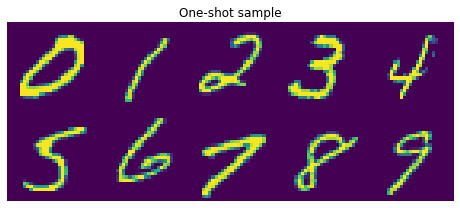

In [7]:
dataset.show_oneshot()

Training set


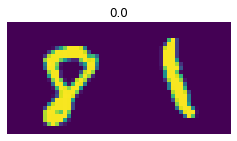

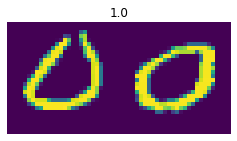

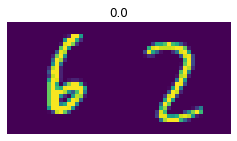

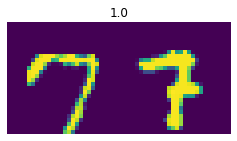

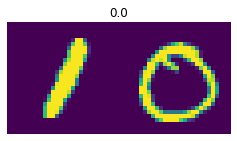

In [8]:
print("Training set")
dataset.show_trainset()

Test set


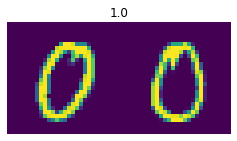

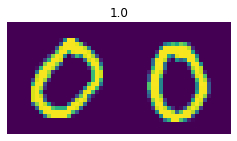

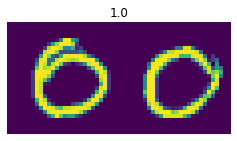

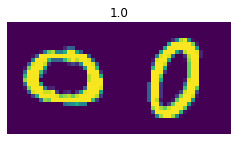

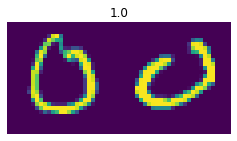

In [9]:
print("Test set")
dataset.show_testset()

Unlabeled


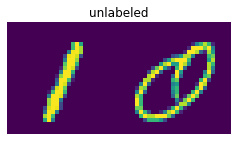

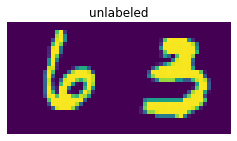

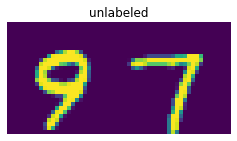

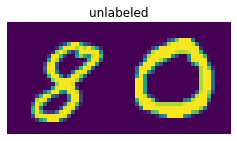

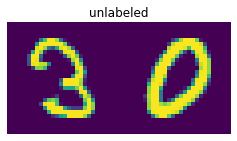

In [10]:
print("Unlabeled")
dataset.show_unlabeled()

# 2. Model

## Nets

In [11]:
class DiscriminativeSNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

        # convolutional layers
        # input: 1 @ 28x28
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),  # 8 @ 28x28
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),  # 8 @ 14x14
            nn.Dropout2d(p=0.5),

            nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2),  # 8 @ 14x14
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),  # 8 @ 7x7
            nn.Dropout2d(p=0.5),
        )

        self.flatten = nn.Flatten()

        # dense layers
        # input: 392
        self.dnn = nn.Sequential(
            nn.Linear(392, 128),
            nn.ReLU(),
        )

        # output: 128

    def _forward(self, x):
        # forward pass of one element of a pair
        return self.dnn(self.flatten(self.cnn(x)))

    def forward(self, input1, input2):
        output1 = self._forward(input1)
        output2 = self._forward(input2)
        return output1, output2


class GenerativeSNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

        # dense layers
        # input: 128
        self.dnn = nn.Sequential(
            nn.Linear(128, 392),
            nn.ReLU(),
        )

        # convolutional layers
        # input: 8 @ 7x7
        self.cnn = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 8 @ 14x14

            nn.ConvTranspose2d(8, 8, kernel_size=5, stride=1, padding=2),  # 8 @ 14x14
            nn.ReLU(),

            nn.Dropout2d(p=0.5),
            nn.Upsample(scale_factor=2),  # 8 @ 28x28

            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),  # 1 @ 28x28
            nn.Sigmoid(),
            
            nn.Dropout2d(p=0.5),
        )

        # output: 1 @ 28x28

    def _forward(self, x):
        # forward pass of one element of a pair
        output = self.dnn(x)
        output = output.view(output.shape[0], 8, 7, 7)
        output = self.cnn(output)
        return output

    def forward(self, input1, input2):
        output1 = self._forward(input1)
        output2 = self._forward(input2)
        return output1, output2

## Loss functions

In [12]:
class ModifiedCrossEntropy(nn.Module):
    def forward(self, outputs1, outputs2, labels):
        distances = F.pairwise_distance(outputs1, outputs2)
        predictions = 1 - distances.tanh()
        return F.binary_cross_entropy(predictions, labels.squeeze(), reduction="sum")


class ReconstructionLoss(nn.Module):
    def forward(self, input, output):
        input = input.flatten(start_dim=1)
        output = output.flatten(start_dim=1)
        distances = F.pairwise_distance(input, output)
        return distances.sum()

# 3. Training and diagnostics

## Model hiperparameters

In [13]:
alpha = 0.05  # importance of the reconstruction loss
beta = 0.1  # l2 regularization
T = 0.5  # threshold
use_unlabeled = True

## Optimization parameters

In [14]:
batch_size = 60
E = 3  # epochs
lr = 0.001  # learning rate

## Data initialization

In [15]:
positive = torch.utils.data.DataLoader(dataset.positive, batch_size=batch_size // 2, shuffle=True)
negative = torch.utils.data.DataLoader(dataset.negative, batch_size=batch_size // 2, shuffle=True)
if use_unlabeled:
    unlabeled = torch.utils.data.DataLoader(dataset.unlabeled, batch_size=batch_size, shuffle=True)
else:
    unlabeled = [None for _ in range(len(dataset.trainset) // batch_size)]

testset = torch.utils.data.DataLoader(dataset.testset, batch_size=len(dataset.testset))

## Training

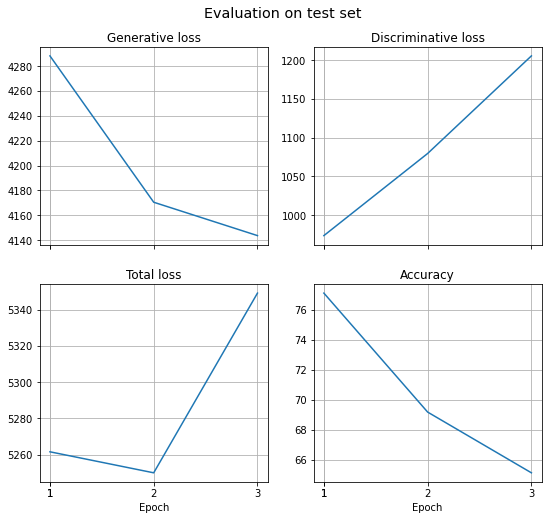

Maximal accuracy: 77.11% (epoch 1).


In [23]:
net1, net2 = DiscriminativeSNN().to(device), GenerativeSNN().to(device)
criterion1, criterion2 = ModifiedCrossEntropy(), ReconstructionLoss()
parameters = [{"params": net1.parameters()}, {"params": net2.parameters()}]
optimizer = torch.optim.RMSprop(parameters, lr=lr, weight_decay=beta)

train_log = {
    "discriminative_loss": [],  # discriminative part of loss
    "generative_loss": [],  # generative part of loss
    "total_loss": [],  # total loss
    "accuracy": [],  # accuracy
    "pos_dists": [],  # predicted distances between positive pairs
    "neg_dists": [],  # predicted distances between negative pairs
}

test_log = {
    "discriminative_loss": [],
    "generative_loss": [],
    "total_loss": [],
    "accuracy": [],
    "pos_dists": [],
    "neg_dists": [],
}

# training
for i in tqdm(range(E)):
    # initialize logs
    train_log["discriminative_loss"].append(0.0)
    train_log["generative_loss"].append(0.0)
    train_log["total_loss"].append(0.0)
    train_log["accuracy"].append([0, 0])
    train_log["pos_dists"].append([])
    train_log["neg_dists"].append([])

    # actual training
    for pos, neg, unlab in zip(it.cycle(positive), it.cycle(negative), unlabeled):
        optimizer.zero_grad()

        ## labeled data
        imgs1, imgs2, labs = pos
        imgs1_, imgs2_, labs_ = neg
        images1 = torch.cat([imgs1, imgs1_], dim=0).to(device)
        images2 = torch.cat([imgs2, imgs2_], dim=0).to(device)
        labels = torch.cat([labs, labs_], dim=0).to(device)

        # first net
        outputs1, outputs2 = net1(images1, images2)
        loss1 = criterion1(outputs1, outputs2, labels)

        # second net
        images1_, images2_ = net2(outputs1, outputs2)
        loss2 = criterion2(images1, images1_) + criterion2(images2, images2_)

        # final loss
        loss = loss1 + alpha * loss2

        # for plots
        train_log["discriminative_loss"][-1] += loss1.item()
        train_log["generative_loss"][-1] += alpha * loss2.item()

        # evaluation on training set
        net1.eval()
        with torch.no_grad():
            outputs1, outputs2 = net1(images1, images2)
            dists = F.pairwise_distance(outputs1, outputs2).tanh()
            preds = (dists <= T).float()
            train_log["accuracy"][-1][0] += len(preds)
            train_log["accuracy"][-1][1] += (
                torch.isclose(labels.squeeze(), preds).sum().item()
            )

            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    train_log["pos_dists"][-1].append(dist.item())
                else:
                    train_log["neg_dists"][-1].append(dist.item())
        net1.train()

        if use_unlabeled: ## unlabeled data
            images1, images2 = (t.to(device) for t in unlab)

            # first net
            outputs1, outputs2 = net1(images1, images2)

            # second net
            images1_, images2_ = net2(outputs1, outputs2)
            loss2 = criterion2(images1, images1_) + criterion2(images2, images2_)

            # total loss
            loss += alpha * loss2

            # for plots
            train_log["generative_loss"][-1] += alpha * loss2.item()

        ## for plots
        train_log["total_loss"][-1] += loss.item()

        ## step
        loss.backward()
        optimizer.step()

    # for plots
    train_log["accuracy"][-1] = (
        100 * train_log["accuracy"][-1][1] / train_log["accuracy"][-1][0]
    )

    test_log["discriminative_loss"].append(0.0)
    test_log["generative_loss"].append(0.0)
    test_log["total_loss"].append(0.0)
    test_log["accuracy"].append(0.0)
    test_log["pos_dists"].append([])
    test_log["neg_dists"].append([])

    # evaluation on test set
    net1.eval()
    net2.eval()
    with torch.no_grad():
        for tensors in testset:
            images1, images2, labels = (t.to(device) for t in tensors)
            outputs1, outputs2 = net1(images1, images2)
            images1_, images2_ = net2(outputs1, outputs2)

            loss1 = criterion1(outputs1, outputs2, labels)
            loss2 = criterion2(images1, images1_) + criterion2(images2, images2_)
            loss = loss1 + alpha * loss2

            test_log["discriminative_loss"][-1] += loss1.item()
            test_log["generative_loss"][-1] += alpha * loss2.item()
            test_log["total_loss"][-1] += loss.item()

            dists = F.pairwise_distance(outputs1, outputs2).tanh()
            preds = (dists <= T).float()

            test_log["accuracy"][-1] += (
                torch.isclose(labels.squeeze(), preds).sum().item()
            )

            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    test_log["pos_dists"][-1].append(dist.item())
                else:
                    test_log["neg_dists"][-1].append(dist.item())
    test_log["accuracy"][-1] /= len(dataset.testset) / 100
    net1.train()
    net2.train()
  

start = 0  # the first epoch to be taken into consideration
domain = range(start + 1, E + 1)
ticks = [start + 1] + list(range(start + max((E - start) // 5, 1), E + 1, max((E - start) // 5, 1))) 

fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharex=True)
fig.suptitle("Evaluation on test set", y=0.95, fontsize="x-large")

axs[0, 0].plot(domain, test_log["generative_loss"][start:])
axs[0, 0].set(title="Generative loss", xticks=ticks)
axs[0, 0].grid()

axs[0, 1].plot(domain, test_log["discriminative_loss"][start:])
axs[0, 1].set(title="Discriminative loss", xticks=ticks)
axs[0, 1].grid()

axs[1, 0].plot(domain, test_log["total_loss"][start:])
axs[1, 0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[1, 0].grid()

axs[1, 1].plot(domain, test_log["accuracy"][start:])
axs[1, 1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1, 1].grid()

plt.show()

best_epoch = np.argmax(test_log['accuracy'])
print(f"Maximal accuracy: {np.max(test_log['accuracy']):.2f}% (epoch {best_epoch + 1}).")

# 4. Diagnostics

## Settings

In [24]:
start = 0  # the first epoch to be taken into consideration
domain = range(start + 1, E + 1)
ticks = [start + 1] + list(range(start + max((E - start) // 5, 1), E + 1, max((E - start) // 5, 1))) 

In [25]:
train_pos_dists = np.array(train_log["pos_dists"][start:])
train_neg_dists = np.array(train_log["neg_dists"][start:])
test_pos_dists = np.array(test_log["pos_dists"][start:])
test_neg_dists = np.array(test_log["neg_dists"][start:])

## Plots

### The process of training - training set

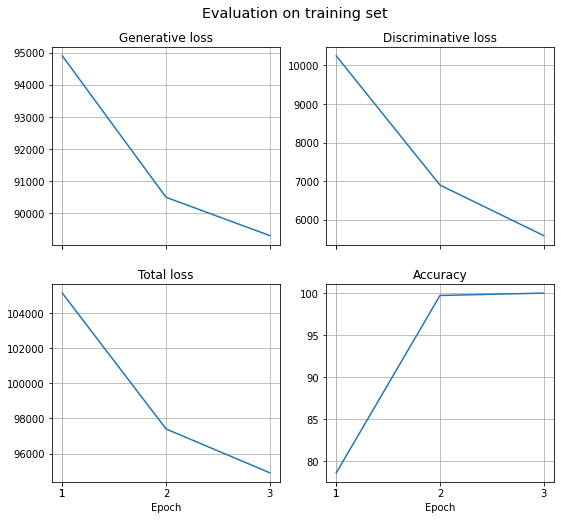

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharex=True)
fig.suptitle("Evaluation on training set", y=0.95, fontsize="x-large")

axs[0, 0].plot(domain, train_log["generative_loss"][start:])
axs[0, 0].set(title="Generative loss", xticks=ticks)
axs[0, 0].grid()

axs[0, 1].plot(domain, train_log["discriminative_loss"][start:])
axs[0, 1].set(title="Discriminative loss", xticks=ticks)
axs[0, 1].grid()

axs[1, 0].plot(domain, train_log["total_loss"][start:])
axs[1, 0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[1, 0].grid()

axs[1, 1].plot(domain, train_log["accuracy"][start:])
axs[1, 1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1, 1].grid()

plt.show()

### The process of training - test set

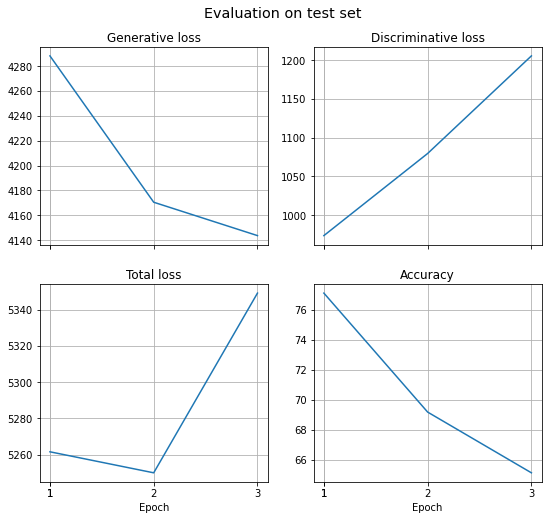

Maximal accuracy: 77.11% (epoch 1).


In [27]:
fig, axs = plt.subplots(2, 2, figsize=(9, 8), sharex=True)
fig.suptitle("Evaluation on test set", y=0.95, fontsize="x-large")

axs[0, 0].plot(domain, test_log["generative_loss"][start:])
axs[0, 0].set(title="Generative loss", xticks=ticks)
axs[0, 0].grid()

axs[0, 1].plot(domain, test_log["discriminative_loss"][start:])
axs[0, 1].set(title="Discriminative loss", xticks=ticks)
axs[0, 1].grid()

axs[1, 0].plot(domain, test_log["total_loss"][start:])
axs[1, 0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[1, 0].grid()

axs[1, 1].plot(domain, test_log["accuracy"][start:])
axs[1, 1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1, 1].grid()

plt.show()

best_epoch = np.argmax(test_log['accuracy'])
print(f"Maximal accuracy: {np.max(test_log['accuracy']):.2f}% (epoch {best_epoch + 1}).")

### Separation of classes during training

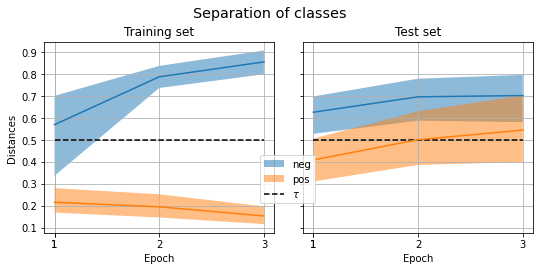

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.suptitle("Separation of classes", fontsize="x-large")

axs[0].set(title="Training set", xlabel="Epoch", ylabel="Distances", xticks=ticks)
axs[0].grid()

q25, q50, q75 = np.percentile(train_neg_dists, [25, 50, 75], axis=1)
axs[0].plot(domain, q50)
axs[0].fill_between(domain, q75, q25, alpha=0.5, label="neg")

q25, q50, q75 = np.percentile(train_pos_dists, [25, 50, 75], axis=1)
axs[0].plot(domain, q50)
axs[0].fill_between(domain, q75, q25, alpha=0.5, label="pos")

axs[0].hlines(T, start + 1, E, label="$\\tau$", linestyles="--")

axs[1].set(title="Test set", xlabel="Epoch", xticks=ticks)
axs[1].grid()

q25, q50, q75 = np.percentile(test_neg_dists, [25, 50, 75], axis=1)
axs[1].plot(domain, q50)
axs[1].fill_between(domain, q75, q25, alpha=0.5)

q25, q50, q75 = np.percentile(test_pos_dists, [25, 50, 75], axis=1)
axs[1].plot(domain, q50)
axs[1].fill_between(domain, q75, q25, alpha=0.5)

axs[1].hlines(T, start + 1, E, linestyles="--")

fig.tight_layout(pad=2.5)
fig.legend(loc=(0.482, 0.25))

plt.show()

### Summary

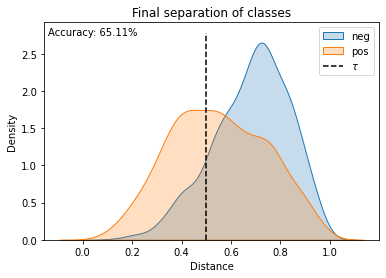

In [29]:
plt.title("Final separation of classes")
sns.kdeplot(test_log["neg_dists"][-1], fill=True, label="neg")
sns.kdeplot(test_log["pos_dists"][-1], fill=True, label="pos")
plt.vlines(T, 0, plt.gca().get_ylim()[1], linestyles="--", label="$\\tau$")
plt.text(
    0.01,
    0.94,
    f"Accuracy: {test_log['accuracy'][-1]:.2f}%",
    transform=plt.gca().transAxes,
)
plt.xlabel("Distance")
plt.legend()
plt.show()

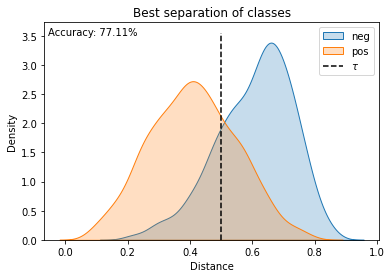

In [30]:
plt.title("Best separation of classes")
sns.kdeplot(test_log["neg_dists"][best_epoch], fill=True, label="neg")
sns.kdeplot(test_log["pos_dists"][best_epoch], fill=True, label="pos")
plt.vlines(T, 0, plt.gca().get_ylim()[1], linestyles="--", label="$\\tau$")
plt.text(
    0.01,
    0.94,
    f"Accuracy: {test_log['accuracy'][best_epoch]:.2f}%",
    transform=plt.gca().transAxes,
)
plt.xlabel("Distance")
plt.legend()
plt.show()